Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [21]:
data = pd.read_csv('../data/num_file/min_05/p040.csv')

In [22]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:45:00      0
2      2022-04-21 01:50:00    241
3      2022-04-21 01:55:00    592
4      2022-04-21 02:00:00     27
...                    ...    ...
38995  2022-09-03 11:15:00   1042
38996  2022-09-03 11:20:00   1913
38997  2022-09-03 11:25:00   2024
38998  2022-09-03 11:30:00   2006
38999  2022-09-03 11:35:00   2170

[39000 rows x 2 columns]


If there is no people, use NaN.

In [23]:
data.loc[data['count']==0, 'count'] = np.NaN

In [24]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:45:00     NaN
2      2022-04-21 01:50:00   241.0
3      2022-04-21 01:55:00   592.0
4      2022-04-21 02:00:00    27.0
...                    ...     ...
38995  2022-09-03 11:15:00  1042.0
38996  2022-09-03 11:20:00  1913.0
38997  2022-09-03 11:25:00  2024.0
38998  2022-09-03 11:30:00  2006.0
38999  2022-09-03 11:35:00  2170.0

[39000 rows x 2 columns]


<Axes: >

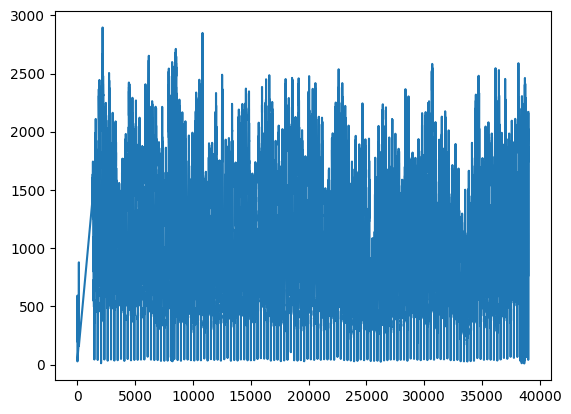

In [25]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

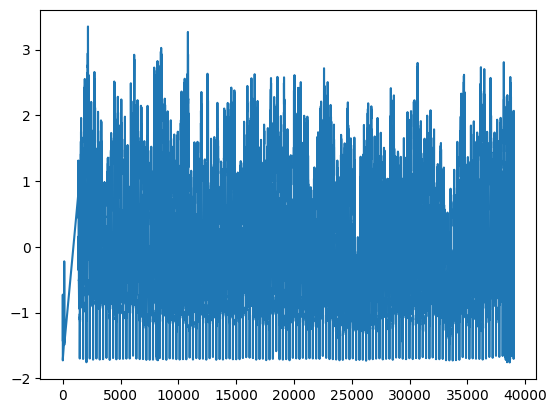

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [27]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.420353
1      2022-04-21 01:45:00 -1.384071
2      2022-04-21 01:50:00 -1.347789
3      2022-04-21 01:55:00 -0.726571
4      2022-04-21 02:00:00 -1.726537
...                    ...       ...
38995  2022-09-03 11:15:00  0.069861
38996  2022-09-03 11:20:00  1.611400
38997  2022-09-03 11:25:00  1.807854
38998  2022-09-03 11:30:00  1.775996
38999  2022-09-03 11:35:00  2.066252

[39000 rows x 2 columns]


In [28]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 10

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [29]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [30]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [31]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [32]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [33]:
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, return_sequences=False, return_state=True)(input_train)

In [34]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [35]:
decoder = RepeatVector(time_step)(encoder_last_h1)
# decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
decoder = LSTM(32, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [36]:
out = TimeDistributed(Dense(1))(decoder)

In [37]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 32),         4352        ['input_3[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 32)          128         ['lstm_2[0][0]']                 
 rmalization)                                                                               

 time_distributed_1 (TimeDistri  (None, 10, 1)       33          ['lstm_3[0][0]']                 
 buted)                                                                                           
                                                                                                  
Total params: 12,961
Trainable params: 12,833
Non-trainable params: 128
__________________________________________________________________________________________________


In [38]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es])

Epoch 1/100
220/220 [==============================] - 10s 20ms/step - loss: 0.0414 - mae: 0.1388 - val_loss: 0.0459 - val_mae: 0.1610
Epoch 2/100
220/220 [==============================] - 4s 17ms/step - loss: 0.0263 - mae: 0.1143 - val_loss: 0.0262 - val_mae: 0.1143
Epoch 3/100
220/220 [==============================] - 3s 15ms/step - loss: 0.0232 - mae: 0.1069 - val_loss: 0.0334 - val_mae: 0.1491
Epoch 4/100
220/220 [==============================] - 3s 15ms/step - loss: 0.0209 - mae: 0.1018 - val_loss: 0.0179 - val_mae: 0.0934
Epoch 5/100
220/220 [==============================] - 4s 16ms/step - loss: 0.0196 - mae: 0.0977 - val_loss: 0.0237 - val_mae: 0.1167
Epoch 6/100
220/220 [==============================] - 3s 15ms/step - loss: 0.0179 - mae: 0.0926 - val_loss: 0.0197 - val_mae: 0.1041
Epoch 7/100
220/220 [==============================] - 3s 15ms/step - loss: 0.0163 - mae: 0.0871 - val_loss: 0.0145 - val_mae: 0.0843
Epoch 8/100
220/220 [==============================] - 3s 15m

In [39]:
model.save('./params/p040_seq2seq.keras')

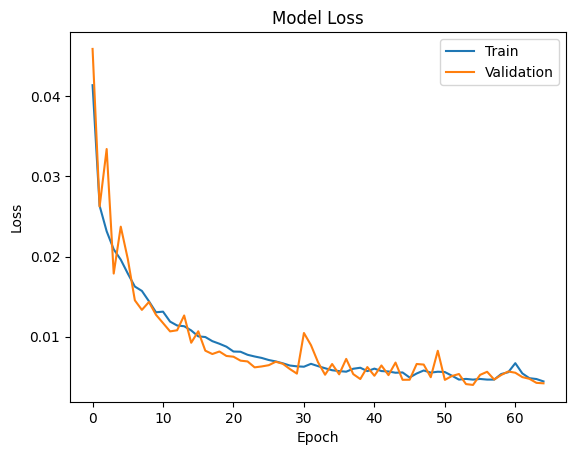

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [41]:
predict_train = model.predict(encode_input_data_train)

975/975 [==============================] - 7s 5ms/step


In [42]:
predict_test = model.predict(encode_input_data_test)

244/244 [==============================] - 1s 6ms/step


In [43]:
print(predict_train.shape)

(31191, 10, 1)


In [44]:
print(predict_test.shape)

(7798, 10, 1)


In [45]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

(38989, 10, 1)


In [46]:
print(predict_test[:, -1, :])

[[-0.34265345]
 [-0.24868602]
 [-0.428842  ]
 ...
 [-0.51941544]
 [ 1.7884727 ]
 [ 1.1263545 ]]


In [47]:
print(decode_output_data_test[:, -1, :])

[[-0.32658531]
 [-0.47348285]
 [-0.41153811]
 ...
 [ 1.6114003 ]
 [ 1.80785364]
 [ 1.77599634]]


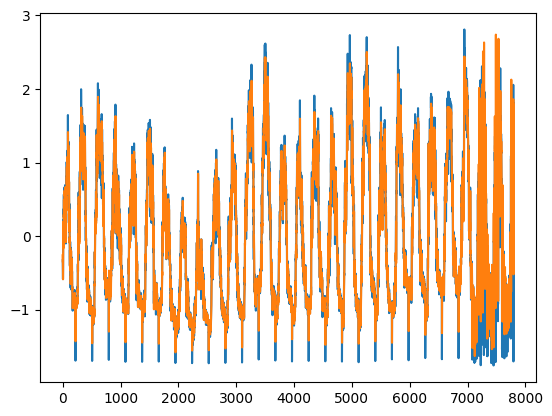

In [48]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

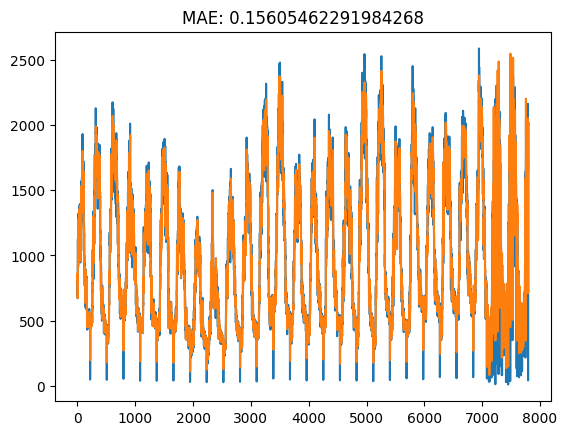

In [49]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)/decode_output_test_data))}')
plt.show()

## Attention

In [50]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [51]:
# encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, activation='relu', return_sequences=True, return_state=True)(input_train)
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='lstm_4/PartitionedCall:1', description="created by layer 'lstm_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_4/PartitionedCall:2', description="created by layer 'lstm_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_4/PartitionedCall:3', description="created by layer 'lstm_4'")


In [52]:
encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [53]:
decoder_input = RepeatVector(time_step)(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='repeat_vector_2/Tile:0', description="created by layer 'repeat_vector_2'")


In [54]:
# decoder_stack_h = LSTM(32, activation='relu', return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
decoder_stack_h = LSTM(32, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='lstm_5/PartitionedCall:1', description="created by layer 'lstm_5'")


In [55]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])

In [56]:
attention = Activation('softmax')(attention)

In [57]:
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [58]:
context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization()(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='batch_normalization_6/batchnorm/add_1:0', description="created by layer 'batch_normalization_6'")


In [59]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 64), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [60]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name=None), name='time_distributed_2/Reshape_1:0', description="created by layer 'time_distributed_2'")


In [61]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 10, 32),     4352        ['input_5[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 32)          128         ['lstm_4[0][1]']                 
 rmalization)                                                                               

In [62]:
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es])

Epoch 1/100
220/220 [==============================] - 13s 28ms/step - loss: 0.0503 - mae: 0.1602 - val_loss: 0.3850 - val_mae: 0.5426
Epoch 2/100
220/220 [==============================] - 5s 24ms/step - loss: 0.0323 - mae: 0.1314 - val_loss: 0.2199 - val_mae: 0.3840
Epoch 3/100
220/220 [==============================] - 7s 30ms/step - loss: 0.0254 - mae: 0.1144 - val_loss: 0.0355 - val_mae: 0.1346
Epoch 4/100
220/220 [==============================] - 5s 25ms/step - loss: 0.0219 - mae: 0.1046 - val_loss: 0.0379 - val_mae: 0.1653
Epoch 5/100
220/220 [==============================] - 9s 41ms/step - loss: 0.0220 - mae: 0.1074 - val_loss: 0.0282 - val_mae: 0.1333
Epoch 6/100
220/220 [==============================] - 7s 31ms/step - loss: 0.0192 - mae: 0.0987 - val_loss: 0.0168 - val_mae: 0.0946
Epoch 7/100
220/220 [==============================] - 7s 30ms/step - loss: 0.0177 - mae: 0.0942 - val_loss: 0.0206 - val_mae: 0.1023
Epoch 8/100
220/220 [==============================] - 5s 23m

In [63]:
model.save('./params/p040_seq2seq_at.keras')

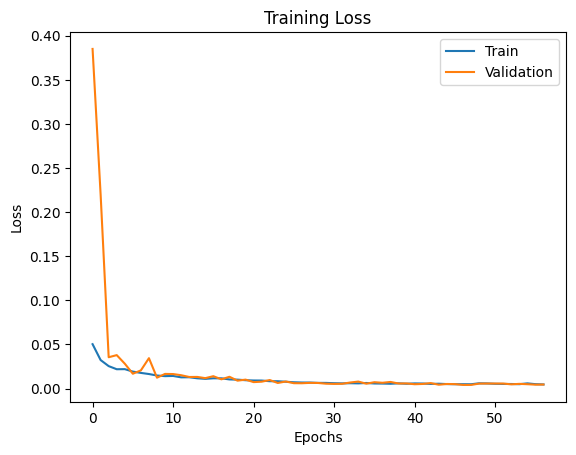

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [65]:
predict_test = model.predict(encode_input_data_test)

244/244 [==============================] - 3s 5ms/step


In [66]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

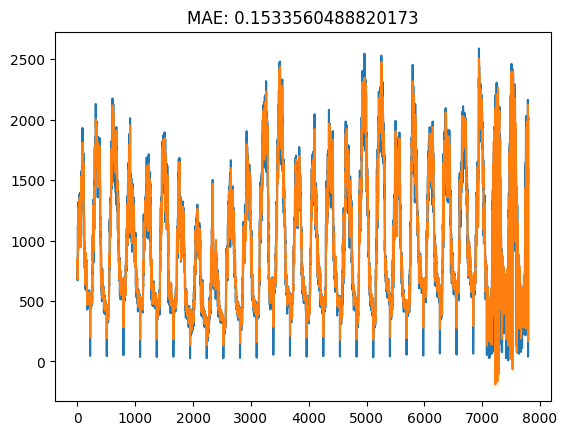

In [67]:
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)/decode_output_test_data))}')
plt.show()

In [68]:
print(predict_test_data)

[[ 796.4735 ]
 [ 844.1856 ]
 [ 742.39294]
 ...
 [ 629.35065]
 [1601.7881 ]
 [1470.2297 ]]


In [69]:
print(decode_output_test_data)

[[ 818.]
 [ 735.]
 [ 770.]
 ...
 [1913.]
 [2024.]
 [2006.]]
